# Sample to calculate mean square displacement using python and FFT

## Summary

This is a sample code to calculate mean square displacement (MSD) via FFT with Python. Trajectories are assumed to be obtained by molecular dynamics simulations, and corrections for periodic boundary conditions are also considered. While the MSD can be obtained by the simple way, it is faster to use FFT. Some codes are adopted from [Stack Overflow](https://stackoverflow.com/questions/34222272/computing-mean-square-displacement-using-python-and-fft).

Commentary articles in Japanese are also [available](https://zenn.dev/kaityo256/articles/msd_fft_python).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random

## Correction of Periodic Boundary Conditions

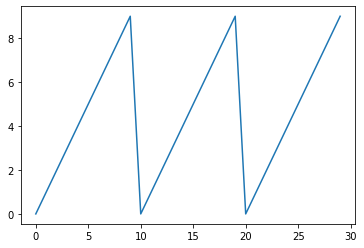

In [2]:
L = 10
x = [i - (i // L)*L  for i in range(L*3)]
plt.plot(x)
plt.show()

In [3]:
def adjust_periodic_wrong(x):
    for i in range(len(x)-1):
        if x[i+1] - x[i] > L/2:
            x[i+1] -= L
        if x[i+1] - x[i] < -L/2:
            x[i+1] += L

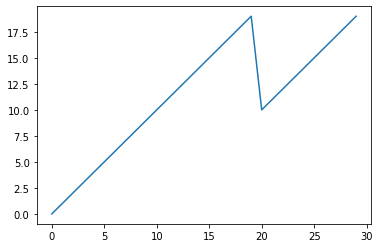

In [4]:
x = [i - (i // L)*L  for i in range(L*3)]
adjust_periodic_wrong(x)
plt.plot(x)
plt.show()


In [5]:
def adjust_periodic(x):
    for i in range(len(x)-1):
        if x[i+1] - x[i] > L/2:
            x[i+1] -= (x[i+1] - x[i]+L/2)//L*L
        if x[i+1] - x[i] < -L/2:
            x[i+1] += (x[i] - x[i+1]+L/2)//L*L

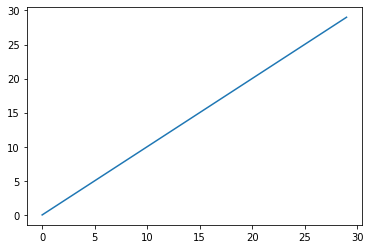

In [6]:
x = [i - (i // L)*L  for i in range(L*3)]
adjust_periodic(x)
plt.plot(x)
plt.show()

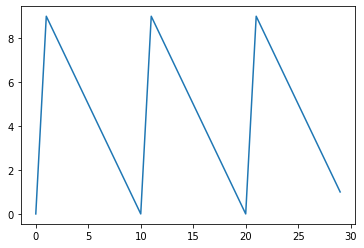

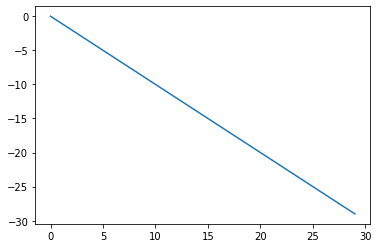

In [7]:
x = [-i - (-i // L)*L  for i in range(L*3)]
plt.plot(x)
plt.show()
adjust_periodic(x)
plt.plot(x)
plt.show()

## Compute trajectory

Compute trajectory of the one-dimensional random walk with periodic boundary condition. The system size is $L$.

In [8]:
def diffusion(step):
    x = np.zeros(step)
    pos = 0.0
    for i in range(step):
        pos += random.choice([-1,1])
        if pos < 0:
            pos += L
        if pos > L:
            pos -= L
        x[i] = pos
    return x

The virtual trajectory in the simulation box.

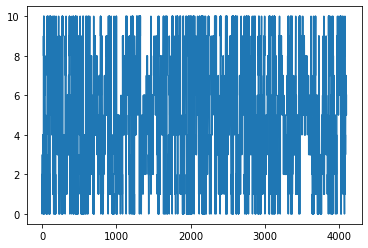

In [9]:
random.seed(12345)
x = diffusion(2**12)
plt.plot(x)
plt.show()

The real trajectory.

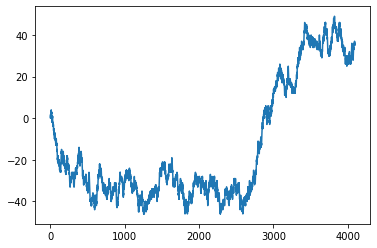

In [10]:
adjust_periodic(x)
plt.plot(x)
plt.show()

## Compute MSD

### Simple Way

In [11]:
def calc_msd_simple(x):
    n = len(x)
    msd = []
    for s in range(1,n//4):
        x2 = 0.0
        for i in range(n-s):
            x2 += (x[i+s]-x[i])**2
        x2 /= (n-s)
        msd.append(x2)
    return msd

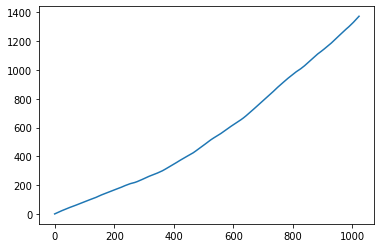

CPU times: user 3.53 s, sys: 17.2 ms, total: 3.54 s
Wall time: 3.57 s


In [12]:
%%time
msd_simple = calc_msd_simple(x)
plt.plot(msd_simple)
plt.show()

### Use NumPy

In [13]:
def calc_msd_np(x):
    n = len(x)
    msd = []
    for s in range(1,n//4):
        dx = x[s:] - x[:-s]
        msd.append(np.average(dx**2))
    return msd


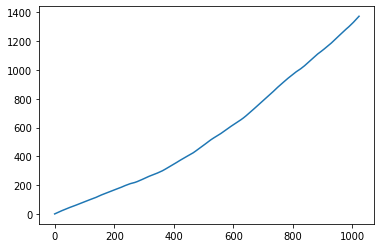

CPU times: user 283 ms, sys: 31.7 ms, total: 315 ms
Wall time: 281 ms


In [14]:
%%time
msd_np = calc_msd_np(x)
plt.plot(msd_np)
plt.show()

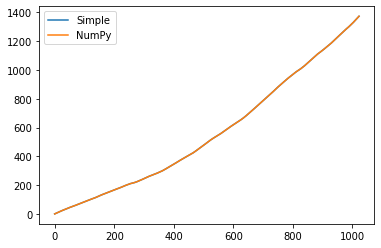

In [15]:
fig, ax = plt.subplots()
ax.plot(msd_simple,label="Simple")
ax.plot(msd_np,label="NumPy")
ax.legend()
plt.show()

### Use FFT

We adopt the following approximation.

$$
s_1 = \frac{1}{N-m} \sum_{k=0}^{N-m-1} \left(x_{k+m}^2 + x_k^2\right)
\sim \frac{2}{N} \sum_{k=0}^{N} x_k^2
$$


In [16]:
def calc_msd_fft(x):
    n=len(x)
    fk = np.fft.fft(x, n=2*n)
    power = fk * fk.conjugate()
    res = np.fft.ifft(power)[:n].real
    s2 = res/(n*np.ones(n)-np.arange(0,n))
    s1 = np.average(x**2)
    msd = 2*s1 - 2*s2
    return msd[:n//4]

CPU times: user 25.1 ms, sys: 952 µs, total: 26 ms
Wall time: 26.4 ms


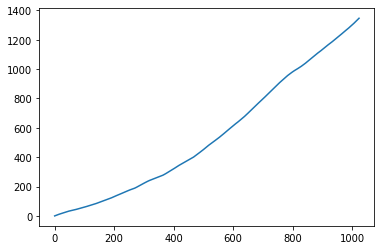

In [17]:
%%time
msd_fft = calc_msd_fft(x)
plt.plot(msd_fft)

The results are slightly deviated due to approximation.

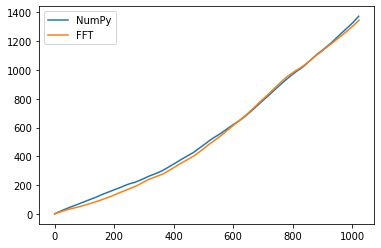

In [18]:
fig, ax = plt.subplots()
msd_np = calc_msd_np(x)
msd_fft = calc_msd_fft(x)
ax.plot(msd_np,label="NumPy")
ax.plot(msd_fft,label="FFT")
ax.legend()
plt.show()

We calculate the following as-is.

$$
s_1 = \frac{1}{N-m} \sum_{k=0}^{N-m-1} \left(x_{k+m}^2 + x_k^2\right)
$$

In [19]:
def calc_msd_fft2(x):
    n=len(x)
    fk = np.fft.fft(x, n=2*n)
    power = fk * fk.conjugate()
    res = np.fft.ifft(power)[:n].real
    s2 = res/(n*np.ones(n)-np.arange(0,n))
    x2 = x**2
    s1 = np.zeros(n)
    s1[0] = np.average(x2)*2.0
    for m in range(1,n):
        s1[m] = np.average(x2[m:] + x2[:-m])
    msd = s1 - 2*s2
    return msd[:n//4]

The results are in perfect agreement with those obtained by the method without FFT.

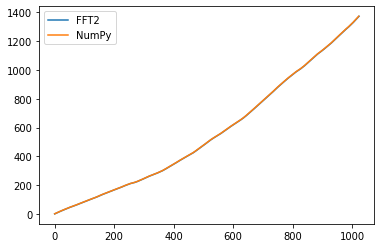

In [20]:
fig, ax = plt.subplots()
msd_np = calc_msd_np(x)
msd_fft2 = calc_msd_fft2(x)
ax.plot(msd_fft2,label="FFT2")
ax.plot(msd_np,label="NumPy")
ax.legend()
plt.show()

## Licence

MIT License

Copyright (c) 2021 - present H. Watanabe

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.